In [1]:
! pip install -q kaggle
! pip install -q keras_cv
import os

!mkdir ~/.kaggle

if not os.path.isfile(os.path.expanduser('~/.kaggle/kaggle.json')):
  from google.colab import files
  print("Upload kaggle.json here")
  files.upload()

!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 650.7/650.7 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 9.9 MB/s eta 0:00:00
Upload kaggle.json here


Saving kaggle.json to kaggle.json


In [2]:
dataset_name = 'pkdarabi/medical-image-dataset-brain-tumor-detection'
zip_name = dataset_name.split('/')[-1]

!kaggle datasets download -d {dataset_name} --force
!unzip -o -q ./{zip_name}.zip -d .

Dataset URL: https://www.kaggle.com/datasets/pkdarabi/medical-image-dataset-brain-tumor-detection
License(s): Attribution 4.0 International (CC BY 4.0)
 88% 49.0M/55.6M [00:01<00:00, 41.5MB/s]
100% 55.6M/55.6M [00:01<00:00, 38.7MB/s]


I have used the following methods.

* I have implemented YOLOV8 model stemmed from this Keras example[1,2],
* Used tf.data for input pipeline,
* I created txt file parser function,

## My Another Segmentation Projects

* [Sport Scene Classification w/ViT (3 KFold CV)](https://www.kaggle.com/code/banddaniel/sport-scene-classification-w-vit-3-kfold-cv)
* [Lung Segmentation UNet w/SeparableConv (Dice:0.93)](https://www.kaggle.com/code/banddaniel/lung-segmentation-unet-w-separableconv-dice-0-93)
* [Brain Tumor Segmentation (detectron2, mAP@50:76.2)](https://www.kaggle.com/code/banddaniel/brain-tumor-segmentation-detectron2-map-50-76-2)

## References
1. https://keras.io/examples/vision/yolov8/
2. Reis, D., Kupec, J., Hong, J., & Daoudi, A. (2023). Real-Time Flying Object Detection with YOLOv8 (Version 1). arXiv. https://doi.org/10.48550/ARXIV.2305.09972

In [3]:
# Importing dependencies

import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm.notebook import tqdm

import tensorflow as tf
from tensorflow.keras import *
from tensorflow.keras.optimizers import AdamW
from tensorflow.keras.callbacks import Callback
import keras_cv


BATCH_SIZE = 32
GLOBAL_CLIPNORM = 10.0

AUTO = tf.data.AUTOTUNE


Using TensorFlow backend


# <span style="color:#e74c3c;"> </span> Preprocessing

Text(0.5, 1.0, 'Image Gray')

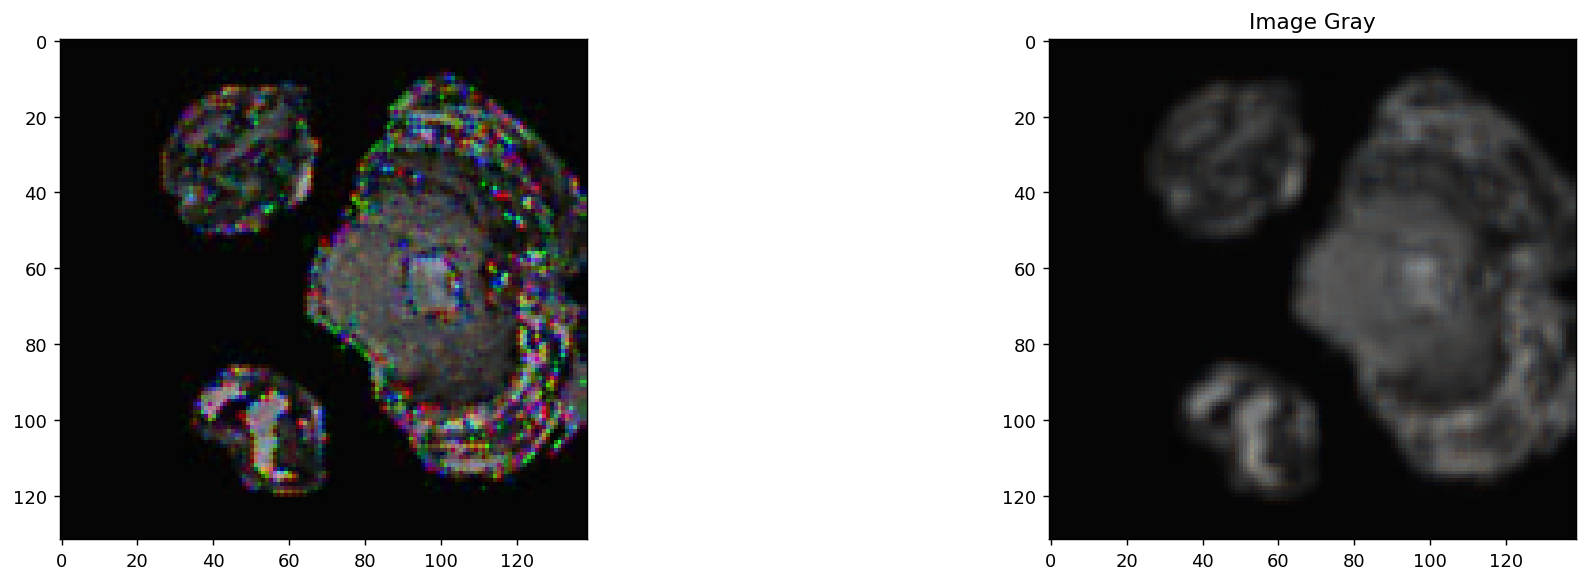

In [42]:
#SUAVIZAÇÃO DA IMAGEM
#carrega a imagem
img_path  = f'slice_34.jpg'
image_gray = cv2.imread(img_path,0)

#Aplica filtro de média
blurred_image = cv2.blur(image_gray,(5,5))

#plota a imagem gray e imagem suavizada

fig, axs = plt.subplots(1,2, figsize = (18,5), dpi=130)
axs[0].imshow(cv2.cvtColor(image_gray,cv2.COLOR_BAYER_BG2BGR))
plt.title('Imagem Suavizada')

axs[1].imshow(cv2.cvtColor(blurred_image,cv2.COLOR_BAYER_BG2BGR))
plt.title('Image Gray')

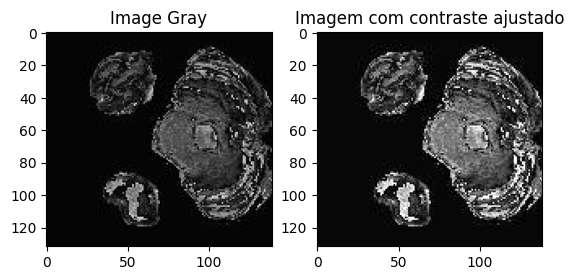

In [38]:
#CONTRASTE LINEAR
rohanced_image = cv2.convertScaleAbs(image_gray, alpha = 1.5, beta =5)

plt.subplot(1,2,1)
plt.imshow(image_gray, cmap='gray')
plt.title('Image Gray')
plt.subplot(1,2,2)
plt.imshow(rohanced_image, cmap='gray')
plt.title('Imagem com contraste ajustado')
plt.show()

In [4]:
# a function for converting txt file to list
def parse_txt_annot(img_path, txt_path):
    img = cv2.imread(img_path)
    w = int(img.shape[0])
    h = int(img.shape[1])

    file_label = open(txt_path, "r")
    lines = file_label.read().split('\n')

    boxes = []
    classes = []

    if lines[0] == '':
        return img_path, classes, boxes
    else:
        for i in range(0, int(len(lines))):
            objbud=lines[i].split(' ')
            class_ = int(objbud[0])

            x1 = float(objbud[1])
            y1 = float(objbud[2])
            w1 = float(objbud[3])
            h1 = float(objbud[4])

            xmin = int((x1*w) - (w1*w)/2.0)
            ymin = int((y1*h) - (h1*h)/2.0)
            xmax = int((x1*w) + (w1*w)/2.0)
            ymax = int((y1*h) + (h1*h)/2.0)

            boxes.append([xmin ,ymin ,xmax ,ymax])
            classes.append(class_)

    return img_path, classes, boxes


# a function for creating file paths list
def create_paths_list(path):
    full_path = []
    images = sorted(os.listdir(path))

    for i in images:
        full_path.append(os.path.join(path, i))

    return full_path


class_ids = ['label0', 'label1', 'label2']
class_mapping = dict(zip(range(len(class_ids)), class_ids))

class_mapping

{0: 'label0', 1: 'label1', 2: 'label2'}

In [5]:
# a function for creating a dict format of files
def creating_files(img_files_paths, annot_files_paths):

    img_files = sorted(create_paths_list(img_files_paths))
    annot_files = sorted(create_paths_list(annot_files_paths))

    image_paths = []
    bbox = []
    classes = []

    for i in range(0,len(img_files)):
        image_path_, classes_, bbox_ = parse_txt_annot(img_files[i], annot_files[i])
        image_paths.append(image_path_)
        bbox.append(bbox_)
        classes.append(classes_)

    image_paths = tf.ragged.constant(image_paths)
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)

    return image_paths, classes, bbox

In [6]:
# applying functions
train_img_paths, train_classes, train_bboxes = creating_files('Brain Tumor Detection/train/images',
                                                              'Brain Tumor Detection/train/labels')

valid_img_paths, valid_classes, valid_bboxes = creating_files('Brain Tumor Detection/valid/images',
                                                              'Brain Tumor Detection/valid/labels')

test_img_paths, test_classes, test_bboxes = creating_files('Brain Tumor Detection/test/images',
                                                            'Brain Tumor Detection/test/labels')

# <span style="color:#e74c3c;"> Creating </span> Datasets

In [7]:
# reading and resizing images
def img_preprocessing(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels = 3)
    img = tf.cast(img, tf.float32)

    return img

noise = keras_cv.layers.JitteredResize(
    target_size=(128, 128),
    scale_factor=(1, 1.5),
    bounding_box_format="xyxy",
)

resizing = keras_cv.layers.Resizing(
    192,
    192,
    pad_to_aspect_ratio=True,
    bounding_box_format="xyxy")

# loading dataset
def load_ds(img_paths, classes, bbox):
    img = img_preprocessing(img_paths)

    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox }

    return {"images": img, "bounding_boxes": bounding_boxes}

def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

In [8]:
#AUMENTANDO OS DADOS
augmenter = Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomContrast(factor=0.5,value_range=[0.0,255.0]), #contraste
        keras_cv.layers.RandomBrightness(factor=0.5,value_range=[0.0,255.0]) #brilho
    ]
)


In [13]:
#BALANCEAMENTO
#train_loader = tf.data.Dataset.from_tensor_slices((train_img_paths, train_classes, train_bboxes))
#print(train_loader)
#classes = tf.concat([labels[1]['classes'] for labels in train_loader.take(-1)], axis=0)
#classes_no_tumor = tf.where(tf.equal(train_loader[1]['classes'], classes))[:,-1]

<_TensorSliceDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), RaggedTensorSpec(TensorShape([None]), tf.int32, 0, tf.int64), RaggedTensorSpec(TensorShape([None, None]), tf.int32, 1, tf.int64))>


TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got 'classes'

In [ ]:
# Creating dataset loaders and tf.datasets
train_loader = tf.data.Dataset.from_tensor_slices((train_img_paths, train_classes, train_bboxes))
train_dataset = (train_loader
                 .map(load_ds, num_parallel_calls = AUTO)
                 .shuffle(BATCH_SIZE*10)
                 .ragged_batch(BATCH_SIZE, drop_remainder = True)
                 .map(augmenter,num_parallel_calls=tf.data.AUTOTUNE)#####
                 .map(resizing, num_parallel_calls=AUTO)
                 .map(dict_to_tuple, num_parallel_calls = AUTO)
                 .prefetch(AUTO))


valid_loader = tf.data.Dataset.from_tensor_slices((valid_img_paths, valid_classes, valid_bboxes))
valid_dataset = (valid_loader
                 .map(load_ds, num_parallel_calls=AUTO)
                 .ragged_batch(BATCH_SIZE, drop_remainder=True)
                 .map(resizing, num_parallel_calls=AUTO)
                 .map(dict_to_tuple, num_parallel_calls=AUTO)
                 .prefetch(AUTO))


test_loader = tf.data.Dataset.from_tensor_slices((test_img_paths, test_classes, test_bboxes))
test_dataset = (test_loader
                .map(load_ds, num_parallel_calls = AUTO)
                .ragged_batch(BATCH_SIZE, drop_remainder = True)
                .map(resizing, num_parallel_calls=AUTO)
                .map(dict_to_tuple, num_parallel_calls = AUTO)
                .prefetch(AUTO))

In [ ]:
# a function to visualize samples from a dataset

def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs[0], inputs[1]

    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale = 8,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
        true_color = (192, 57, 43))

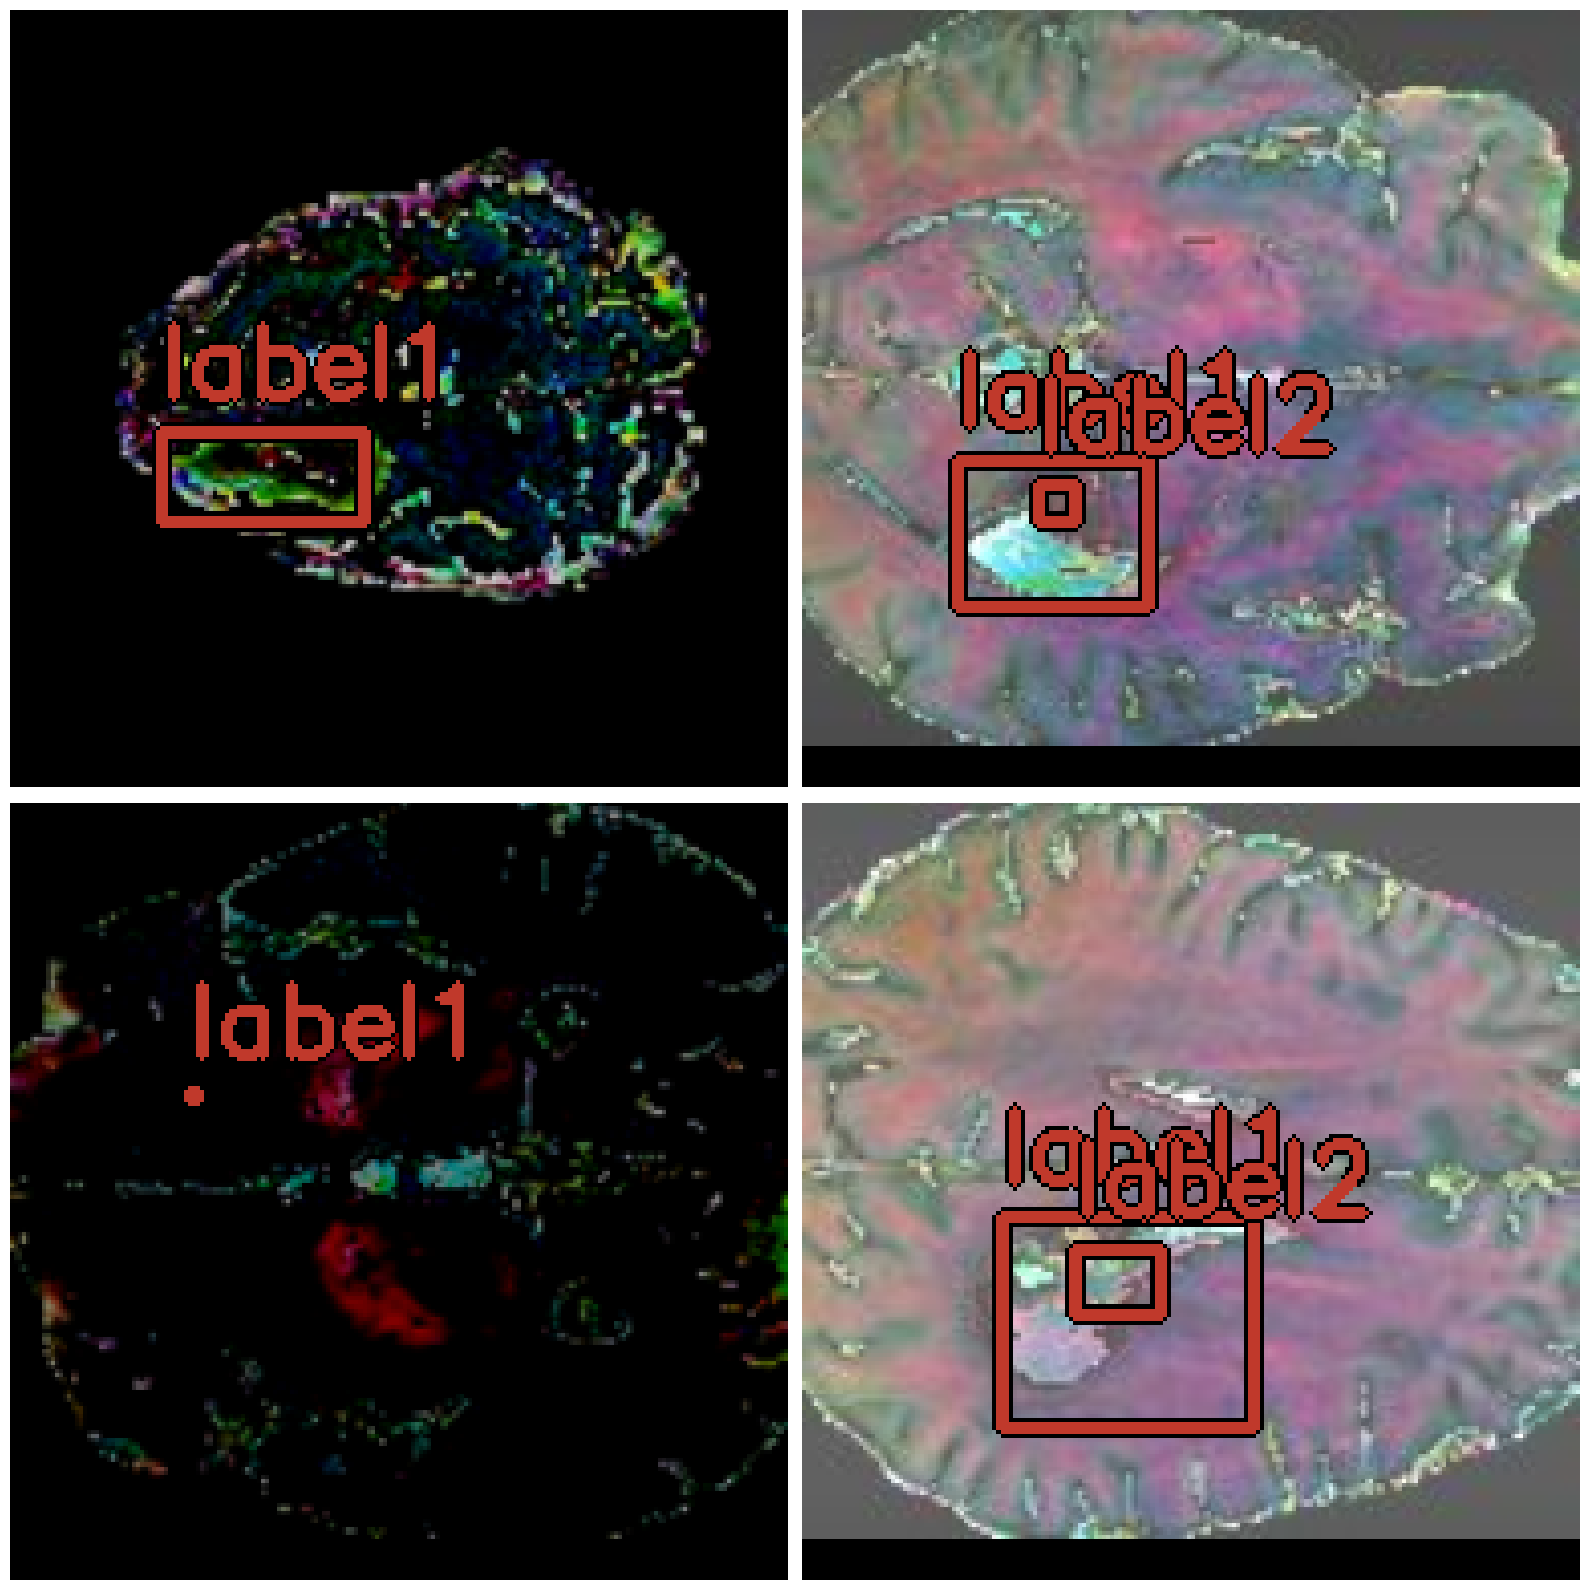

In [ ]:
# examples images and annotations from training daatset
visualize_dataset(train_dataset, bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2)

# <span style="color:#e74c3c;"> YOLO V8</span> Model

In [ ]:
# creating mirrored strategy

stg = tf.distribute.MirroredStrategy()

In [ ]:
from keras.callbacks           import ReduceLROnPlateau
from keras.callbacks           import EarlyStopping
# creating pre-trained model backbone with coco weights

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                                            patience=3, verbose=1, mode='min',
                                            min_lr=0.00001)

early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1,
                           mode='min', restore_best_weights=True)

with stg.scope():
    backbone = keras_cv.models.YOLOV8Backbone.from_preset("yolo_v8_xs_backbone_coco")

    YOLOV8_model = keras_cv.models.YOLOV8Detector(num_classes=len(class_mapping),
                                              bounding_box_format="xyxy",
                                              backbone=backbone, fpn_depth=1)

    optimizer = AdamW(#learning_rate=0.0001,
                      #weight_decay=0.004,
                      global_clipnorm=GLOBAL_CLIPNORM
                      )

    YOLOV8_model.compile(optimizer=optimizer, classification_loss='binary_crossentropy', box_loss='ciou')

/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids
/usr/local/lib/python3.10/dist-packages/keras_cv/src/models/backbones/backbone.py:44: UserWarning: `layer.updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  return id(getattr(self, attr)) not in self._functional_layer_ids


In [ ]:
YOLOV8_model.save(f'{os.getcwd()}/yolo_tmp.keras')

# <span style="color:#e74c3c;"> Training </span>

In [ ]:
!pip install pycryptodomex -q

from Cryptodome.Hash import SHA512
import numpy as np
import cv2   as cv


hash_function = SHA512.new()


def count_duplicates(data_dir: str) -> tuple[int, list]:
    '''
    Counts duplicated images and which of them aren't tumourous
    '''
    no_tumour = 0
    images, labels, hashes = list(), list(), list()

    for filename in os.listdir(os.path.join(data_dir, 'images')):

        if filename.endswith('.jpg') or filename.endswith('.png'):

            img_path = os.path.join(data_dir, 'images', filename)
            img = cv.imread(img_path)

            # Calculates the hash for each image (needs conversion to bytes)
            _, image_bytes = cv.imencode('.jpg', img)
            image_bytes = image_bytes.tobytes()
            hash_function.update(image_bytes)
            img_hash = hash_function.hexdigest()
            hashes.append(img_hash)

            label_path = os.path.join(data_dir, 'labels', filename.replace('.jpg', '.txt'))

            if os.path.isfile(label_path):
                with open(label_path, 'r') as label_file:
                    line = label_file.readline().strip()

                    if not line:
                        no_tumour += 1
                        continue

    return no_tumour, hashes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.3 MB/s eta 0:00:00


In [ ]:
image_hashes = list()
total_images, n_labels, unlabeled = 0, 0, 0
dirs = ['Brain Tumor Detection/train', 'Brain Tumor Detection/valid', 'Brain Tumor Detection/test']

for dir in dirs:
    partial_unlabeled, partial_hash = count_duplicates(data_dir=dir)
    unlabeled += partial_unlabeled
    image_hashes += partial_hash
    n_labels += len(os.listdir(f'{dir}/labels'))
    total_images += len(os.listdir(f'{dir}/images'))

proportion = (unlabeled / total_images) * 100
duplicates = len(image_hashes) - len(list(set(image_hashes)))
print(f'Total amount of images: {total_images}')
print(f'Total amount of labels: {n_labels}')
print(f'Amount of images with no tumors: {unlabeled} ({round(proportion, 2)}%)')
print(f'Redundant images: {duplicates}')


Total amount of images: 9900
Total amount of labels: 9900
Amount of images with no tumors: 113 (1.14%)
Redundant images: 0


In [ ]:
#DIMINUINDO DATASET
from sklearn.utils.class_weight import compute_class_weight

#train_classes =[labels['classes'] for _,labels in train_dataset.take(-1)]
#class_weights = compute_class_weight('balanced',classes=[0,1,2,3], y=train_classes)
hist = YOLOV8_model.fit(train_dataset, class_weights={}, validation_data=valid_dataset, epochs=50, callbacks=[learning_rate_reduction, early_stop])

NameError: name 'YOLOV8_model' is not defined

# <span style="color:#e74c3c;"> Training </span> Results, Evaluation

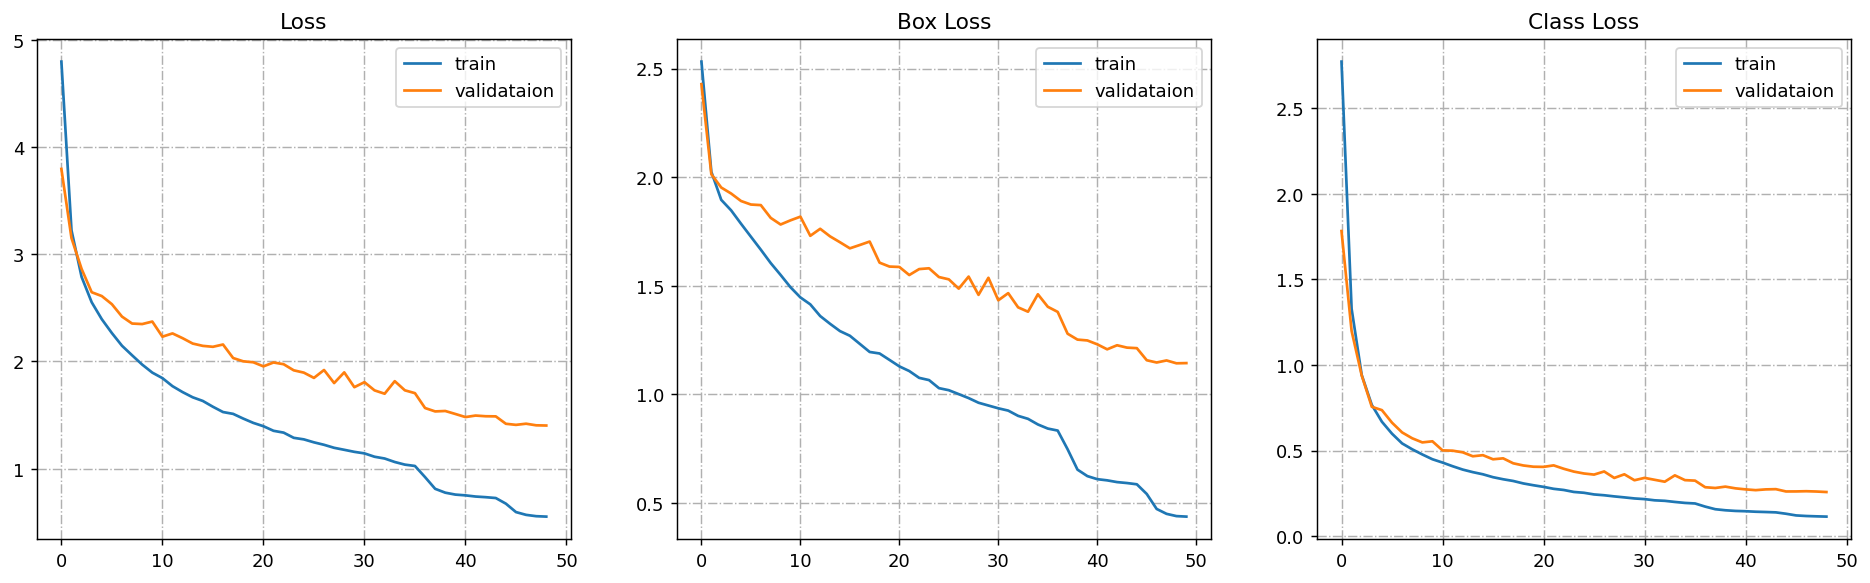

In [ ]:
fig, axs = plt.subplots(1,3, figsize = (18,5), dpi = 130)

axs[0].grid(linestyle="dashdot")
axs[0].set_title("Loss")
axs[0].plot(hist.history['loss'][1:])
axs[0].plot(hist.history['val_loss'][1:])
axs[0].legend(["train", "validataion"])

axs[1].grid(linestyle="dashdot")
axs[1].set_title("Box Loss")
axs[1].plot(hist.history['box_loss'])
axs[1].plot(hist.history['val_box_loss'])
axs[1].legend(["train",  "validataion"])

axs[2].grid(linestyle="dashdot")
axs[2].set_title("Class Loss")
axs[2].plot(hist.history['class_loss'][1:])
axs[2].plot(hist.history['val_class_loss'][1:])
axs[2].legend(["train",  "validataion"])

# axs[3].grid(linestyle="dashdot")
# axs[3].set_title("Accuracy")
# axs[3].plot(hist.history['accuracy'][1:])
# axs[3].plot(hist.history['val_accuracy'][1:])
# axs[3].legend(["train",  "validataion"])

# <span style="color:#e74c3c;"> Test </span> Predictions

In [ ]:
def visualize_predict_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))

    y_pred = model.predict(images)
    y_pred = keras_cv.bounding_box.to_ragged(y_pred)
    print(y_pred)

    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        true_color = (192, 57, 43),
        pred_color=(255, 235, 59),
        scale = 8,
        font_scale = 0.8,
        line_thickness=2,
        dpi = 100,
        rows=2,
        cols=2,
        show=True,
        class_mapping=class_mapping,
    )

1/1 [==============================] - 3s 3s/step
{'boxes': <tf.RaggedTensor [[], [[62.547127, 6.833317, 91.72552, 40.016563],
      [71.57887, 22.077686, 139.44936, 48.835426],
      [58.559555, 8.168832, 124.38852, 48.89183]] ,
 [[61.612946, 7.8980427, 92.352776, 39.1433],
  [62.378357, 5.092333, 95.38845, 45.071846]],
 [[54.963417, 2.3097458, 112.423676, 45.937923],
  [42.546032, 4.5685277, 150.35283, 58.36672],
  [62.98566, 131.76788, 80.45042, 149.26146]]   , [],
 [[51.372894, 107.33669, 133.14613, 175.70554],
  [63.44138, 99.50578, 127.98616, 152.85886]]  , [], [], [],
 [[126.31792, 120.39003, 181.59608, 172.58328],
  [107.87405, 119.31062, 179.34552, 173.8426]] ,
 [[53.101994, 2.9450035, 119.902115, 60.616634],
  [39.26124, 1.8721218, 150.06062, 91.475296]]  ,
 [[34.528675, 22.02737, 87.1463, 70.10568],
  [46.37364, 28.656397, 70.806885, 57.161102]],
 [[46.416687, 30.908733, 78.80896, 62.773872],
  [43.30806, 25.240192, 91.98122, 76.53758]]  , [],
 [[35.51655, 102.301216, 88.204

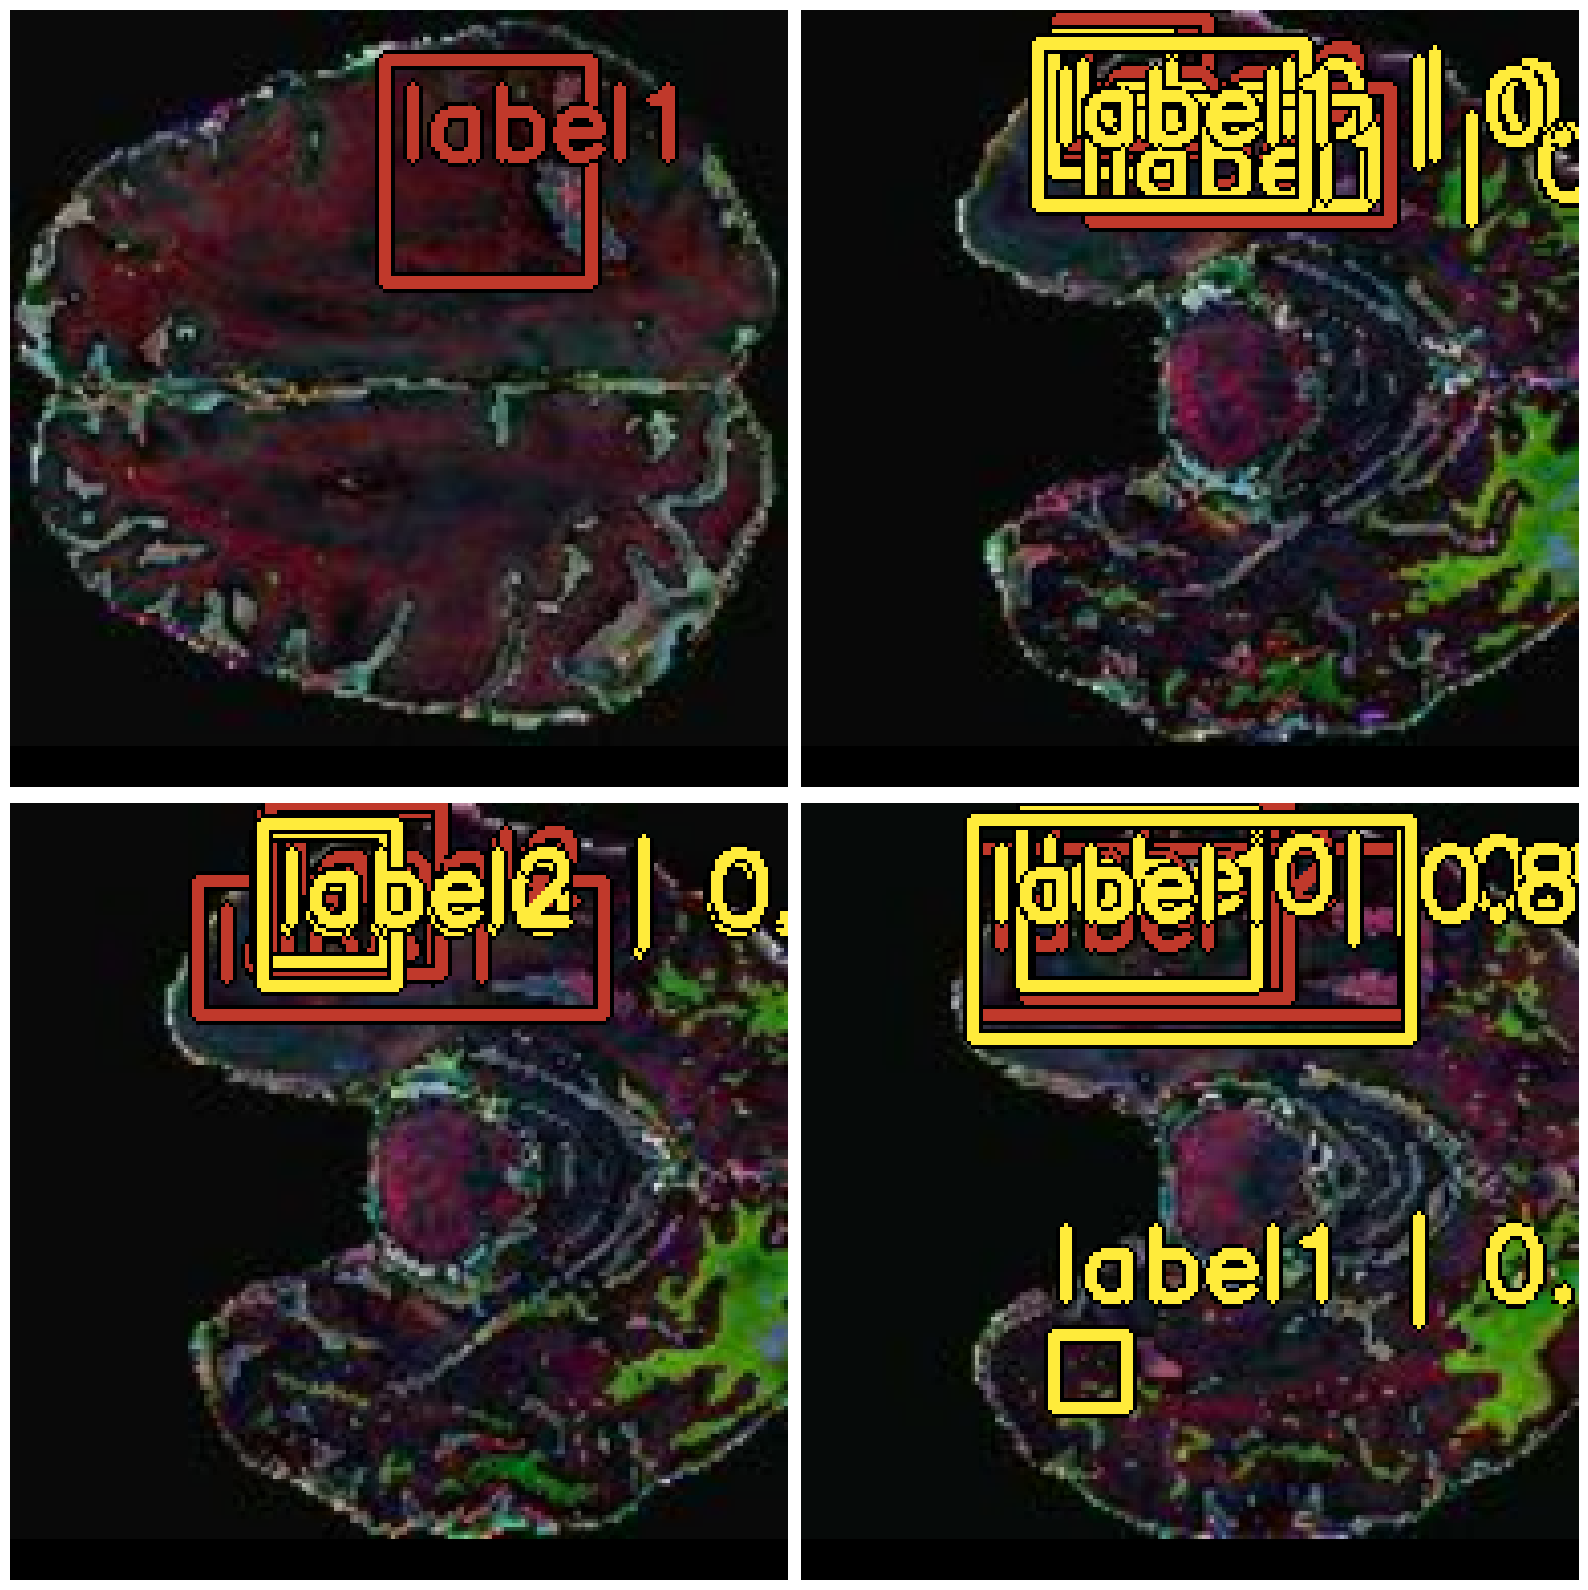

In [ ]:
# red -> ground true
# yellow -> prediction

visualize_predict_detections(YOLOV8_model, dataset = test_dataset, bounding_box_format="xyxy")